In [1]:
import pandas as pd
import numpy as np
import urllib.parse
import requests

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pingouin as pg

<div id="top"></div>

## Академический проект _"Анализ результатов А/В тестирования"_
### Формализация задачи
В ходе тестирования гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

При этом часть данных была передана позже основного пакета. Напишем функцию для пересчета метрик и выводу графиков на основании добавленных данных.  

### Входные данные

В качестве входных данных были предоставлены 4 csv-файла, загруженные на Яндекс Диск:
 * [groups.csv](https://disk.yandex.ru/d/UhyYx41rTt3clQ) – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контрольная, B – тестовая).
 * [groups_add.csv](https://disk.yandex.ru/d/5Kxrz02m3IBUwQ) – дополнительный файл с пользователями, *который был передан спустя 2 дня после передачи данных.*
 * [active_studs.csv](https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ) – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
 * [checks.csv](https://disk.yandex.ru/d/pH1q-VqcxXjsVA) – файл с информацией об оплатах пользователей в дни проведения эксперимента. 
 
### Предварительный список вопросов

 1. Какие метрики могут быть показателями наличия / отсутствия разницы между контрольной и тестовой группами? ([перейти к вопросу](#point1))
 2. Есть ли различия в показателях? ([перейти к вопросу](#point2))
 3. Являются ли эти различия статистически значимыми? ([перейти к вопросу](#point3))  
 4. Написать функцию для подгрузки дополнительных данных и пересчета метрик с их учетом ([перейти к вопросу](#point4))  
 5. Стоит ли раскатывать новую механику на всех пользователей? ([перейти к вопросу](#point5))

### Подгрузим данные по ссылкам
Подгружать пока будем лишь изначальные данные - за исключением дополнительного файла с пользователями, который был передан спустя 2 дня после передачи основного пакета

In [2]:
#запишем в словарь название фреймов и соответствующие ссылки для загрузки 
links_to_parse = {'groups': 'https://disk.yandex.ru/d/UhyYx41rTt3clQ', 
                  'active': 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                  'payments': 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
                 }

In [3]:
#напишем функцию для считывания фрейма из файлов по ссылке 

def link_parser(name, link):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urllib.parse.urlencode(dict(public_key=link))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url, delimiter = ";")

#применим функцию для всех фреймов в словаре и запишем фрейм в переменные с названиями, соответствующими ключам словаря
for name, public_link in zip(links_to_parse.keys(), links_to_parse.values()):
    locals()[name] = link_parser(name, public_link)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


#### Изучим фрейм groups

Фрейм содержит информацию о принадлежности пользователя к контрольной или экспериментальной группе (А – контрольная, B – тестовая)

In [4]:
#выведем первые строки
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
#оценим количество записей и полей
print(f'Размер фрейма groups: {groups.shape}')

#выведем типы данных
groups.dtypes

#типы данных считаны корректно

Размер фрейма groups: (74484, 2)


id      int64
grp    object
dtype: object

In [6]:
#проверим на наличие пропусков
groups.isna().sum()

#пропуски отсутствуют 

id     0
grp    0
dtype: int64

In [7]:
#проверим на наличие дублей
groups.loc[groups.duplicated()]

#дубли отсутствуют 

,id,grp


In [8]:
#проверим, сколько пользователей попало в контрольную и сколько в тестовую группы
groups.groupby('grp').count()

#В тестовую группу попало 59 813 юзеров, а в контрольную - 14 671

,id
grp,
A,14671
B,59813


##### Промежуточный вывод по фрейму groups:
Итого предполагалось, что в А/В тестировании примут участие <b>74 484 человека</b>, которые были поделены на контрольную и тестовую группы  

    
Разделение на контрольную и тестовую группы неравномерное: в контрольной группе <b>14 671 пользователей</b>, в то время как в тестовой - <b>59 813 юзеров</b> <i>(распределение примерно 20:80)</i>. 
    
<i>Соответственно, есть вопросы к работе системы сплитования</i>
***

#### Изучим фрейм active

Фрейм содержит информацию о пользователях, которые зашли на платформу в дни проведения эксперимента.

In [9]:
#выведем первые строки
active.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [10]:
#оценим количество записей и полей
print(f'Размер фрейма active: {active.shape}')

#активных пользователей в дни эксперимента было гораздо меньше, чем число значений во фрейме groups (8341 против 74484)
#все пользователи были поделены на группы заранее (а не относились в ту или иную группу по факту захода в продукт)
#лишь некоторые из распределенных по контрольной и тестовой группам пользователей в итоге приняли участие в эксперименте 

#выведем типы данных
active.dtypes

#типы данных считаны корректно

Размер фрейма active: (8341, 1)


student_id    int64
dtype: object

In [11]:
#проверим на наличие пропусков
active.isna().sum()

#пропуски отсутствуют 

student_id    0
dtype: int64

In [12]:
#проверим на наличие дублей
active.loc[active.duplicated()]
#дубли отсутствуют 

,student_id


##### Промежуточный вывод по фрейму active: 

Итого в дни проведения эксперимента из 74 484 пользователей были активны лишь <b>8 341</b> <i>(примерно 11%)</i> 
    
Фактическую численность контрольной и тестовой групп можно будет знать только после объединения фреймов groups и active
***

#### Изучим фрейм payments

Фрейм содержит информацию об оплатах пользователей в дни проведения эксперимента

In [13]:
#выведем первые строки
payments.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [14]:
#оценим количество записей и полей
print(f'Размер фрейма payments: {payments.shape}')

#число строк существенно меньше, чем во фрейме active 
#лишь 541 пользователь совершил покупку в дни проведения эксперимента

#выведем типы данных
payments.dtypes

#типы данных считаны корректно

Размер фрейма payments: (541, 2)


student_id      int64
rev           float64
dtype: object

In [15]:
#проверим на наличие пропусков
payments.isna().sum()

#пропуски отсутствуют 

student_id    0
rev           0
dtype: int64

In [16]:
#проверим на наличие дублей по student_id
payments.loc[active.duplicated(subset='student_id')]
#дубли отсутствуют - т.е. каждый клиент совершил по одной оплате

,student_id,rev


In [17]:
#выведем общую выручку и описательные статистики по выручке
print(f'Итоговая выручка за дни эксперимента равняется {payments.rev.sum().round()}')
payments.rev.describe()

#NB: данные малоинформативны, т.к. нет понимания, какой механикой оплаты пользовались юзеры

Итоговая выручка за дни эксперимента равняется 573326.0


count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [18]:
#проверим, есть ли в payments информация о пользователях, которые совершили оплату, но не попали во фрейм active

print(f'Во фрейме active нет информации о {payments.query("student_id not in @active.student_id").student_id.count()} платящих' 
      f' пользовател{"е" if (payments.query("student_id not in @active.student_id").student_id.count()%10 == 1) else "ях"}'
      f' (примерно '
      f'{(payments.query("student_id not in @active.student_id").student_id.count()/(payments.shape[0])*100).round(2)}'
      f'% от всех пользователей во врейме payments)')


Во фрейме active нет информации о 149 платящих пользователях (примерно 27.54% от всех пользователей во врейме payments)


##### Промежуточный вывод по фрейму payments: 

Во фрейме содержится информация о сумме выручки и ID соответствующего юзера. Медианный чек по платящему клиенту <i>(без разделения на тестовую и контрольную группы)</i> равняется <i>840</i>, а средняя выручка - примерно <i>1060</i>. Это говорит о том, что распределение скорее всего не является нормальным. 

Итого в дни проведения эксперимента покупку совершил лишь <b>541 пользователь</b>. 

Также во фрейме active нет информации <b>о 149 платящих пользователях</b>, информация о которых содержится во фрейме payments. Такое может быть обусловлено двумя причинами:  
    1) баг системы сбора данных;  
    2) оплаты были совершены без захода в приложение <i>(например, в случае периодических платежей при наличии подписки)</i>. 
    
Так как в моменте у нас нет возможности проверить систему сбора данных на наличие багов, в рамках дальнейших шагов исследования мы предположим, что случился второй из описанных сценариев <i>(т.е. средства были списаны в результате регулярной подписки)</i>. 
    
Если пользователи, которые совершили оплату в дни эксперимента, отсутствуют во фрейме active, то их средства были списаны в оплату подписки без захода в приложение. Т.к. в продукт данные пользователи не заходили, воспользоваться новым методом оплаты они не могли - <b>значит, на показатели данных пользователей новая механика не повлияла.</b> В дальнейших шагах исследования такую группу пользователей рассматривать мы не будем.
***

### Создадим объединенный фрейм из трех источников, которые были переданы изначально



In [19]:
#объединим active с groups и payments, оставив только данные об активных пользователях из active
full_df = active.merge(groups.rename(columns={'id':'student_id'}), how='left')\
                .merge(payments, how='left') 

In [20]:
#выведем начало полученного фрейма
full_df.head()


,student_id,grp,rev
0,581585,A,NaN
1,5723133,NaN,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [21]:
#посмотрим на размер фрейма
full_df.shape

#число строк совпадаем с числом пользователей в active - так и должно быть

(8341, 3)

In [22]:
#проверим число пропусков 
full_df.isna().sum()


student_id       0
grp             13
rev           7949
dtype: int64

In [23]:
#видим 13 пропусков в поле grp - возможно, информация о данных пользователях содержится в том фрейме, который был передан позже
#пока что исключим данных пользователей из рассмотрения и запишем данные о них в отдельный фрейм

no_group_df = full_df.loc[full_df.grp.isna()]
group_df = full_df.loc[full_df.grp.notna()]

#для проверки выведем размеры обоих фреймов

print(f'Размер фрейма no_group_df составляет : {no_group_df.shape}')
print(f'Размер фрейма group_df составляет : {group_df.shape}')

Размер фрейма no_group_df составляет : (13, 3)
Размер фрейма group_df составляет : (8328, 3)


In [24]:
#проверим полученный фрейм на дубликаты по student_id
group_df.loc[full_df.duplicated(subset='student_id')]

#дубликатов нет
#получается, в нашем фрейме все покупки клиента в дни эксперимента записаны одной строкой

,student_id,grp,rev


<div id="point1"></div>

### 1. Какие метрики могут быть показателями наличия / отсутствия разницы между контрольной и тестовой группами? ([в начало](#top))
Исходя из имеющихся данных, выберем для оценки эффекта новой механики оплаты следующие метрики:

1) конверсия в оплату (*т.е. сам факт совершения покупки говорит о том, что новая механика позволила конвертировать активного пользователя в платящего*)  
2) доход с платящего пользователя (*т.е. ввиду более удобной механики совершения платежей платящие пользователи стали тратить больше денег в продукте*)

#### Для начала посмотрим на основные метрики по тестовой и контрольной группам (ARPU, ARPPU, доля платящих пользователей)

In [25]:
#посмотрим на основные метрики в разрезе групп
group_df.groupby('grp', as_index=False)\
        .agg(active_users =('student_id', 'count'),
             paying_users =('rev', lambda x: x.count() if (x>0).any() else 0),
             total_revenue=('rev', 'sum')
            )\
        .assign(ARPU        =lambda x: x.total_revenue.div(x.active_users),
                ARPPU       =lambda x: x.total_revenue.div(x.paying_users),
                prcnt_paying=lambda x: x.paying_users.div(x.active_users).mul(100)
               )\
        .round(2)
        

,grp,active_users,paying_users,total_revenue,ARPU,ARPPU,prcnt_paying
0,A,1535,78.0,72820.0,47.44,933.59,5.08
1,B,6793,313.0,393074.0,57.86,1255.83,4.61


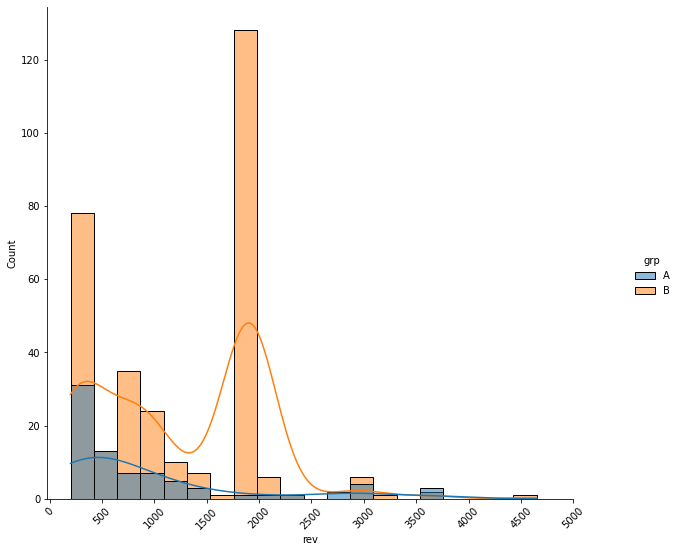

In [26]:
#посмотрим на распределение среднего чека платящих юзеров
fig_a = sns.displot(data=group_df.query('rev>0'), x='rev', hue='grp', kde=True, bins=20)
fig_a.fig.set_size_inches(10,8)
plt.xticks(rotation=45)
plt.xticks(np.arange(0, 5500, 500))
plt.show()
#визуально наблюдаем, что в основном средний чек по группе В превышает средний чек по группе А

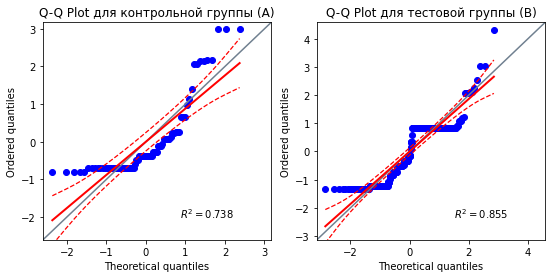

In [27]:
#очевидно, что распределение среднего чека не является нормальным. Для практики посмотрим на qq plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1 = pg.qqplot(x=group_df.query('rev>0 & grp=="A"').rev, ax=ax1)
ax2 = pg.qqplot(x=group_df.query('rev>0 & grp=="B"').rev, ax=ax2)
ax1.set_title('Q-Q Plot для контрольной группы (А)')
ax2.set_title('Q-Q Plot для тестовой группы (В)')
plt.show()


In [28]:
#посмотрим на среднее и стандартное отклонение для пользователей с ненулевой суммой покупок
group_df.query('rev>0').groupby('grp').rev.agg(['mean', 'std']).round(3)


,mean,std
grp,,
A,933.590,919.933
B,1255.827,791.293


Видим, что стандартное отклонение для пользователей с ненулевой суммой покупок в группах отличается. Т.к. разность дисперсий может повлиять в дальнейшем на результаты статистических тестов, необходимо провести проверку наших данных по выборке на гомоскедастичность. **Для этого применим критерий Левена**. 

Зафиксируем наши гипотезы: 

$H_0$: Дисперсия выручки в тестовой группе **равна** дисперсии выручки в контрольной группе *(учитываются лишь ненулевые значения)*.  
$H_1$: Дисперсия выручки в тестовой группе **отличается** от дисперсии выручки в контрольной группе *(учитываются лишь ненулевые значения)*.  

Уровень p-значимости зафиксируем на 0.05.


In [29]:
a_levene = 0.05
levene_results = pg.homoscedasticity(group_df.query('rev>0'), dv='rev', group='grp')
print(f'Уровень р-значимости по критерию Левена составил {levene_results.pval[0].round(3)}')
if levene_results.pval[0].round(3) > a_levene:
    print(f'Уровень p-значимости не позволяет отклонить нулевую гипотезу о равенстве '
          f'дисперсий выручки в контрольной и тестовой группах')
else: 
    print(f'Уровень p-значимости позволяет отклонить нулевую гипотезу о равенстве '
          f'дисперсий выручки в контрольной и тестовой группах')
levene_results

Уровень р-значимости по критерию Левена составил 0.081
Уровень p-значимости не позволяет отклонить нулевую гипотезу о равенстве дисперсий выручки в контрольной и тестовой группах


,W,pval,equal_var
levene,3.055864,0.081235,True


##### Промежуточные выводы по выбранным метрикам (CR и ARPPU):  
    
1. Распределение между контрольной и тестовой группами неравномерное. Численность тестовой группы (B) примерно в 4.5 раза <b>больше</b>, чем численность контрольной (А)
    
2. Как ARPU, так и ARPPU в контрольной группе (А) <b>меньше</b>, чем в тестовой (В)  
    
3. При этом доля платящих пользователей в контрольной группе (А) <b>больше</b>, чем в тестовой (В)
    
4. Среднеквадратическое отклонение в контрольной группе (A) больше, чем в тестовой (В). Тем не менее, результаты теста Левена для проверки гомоскедастичности показали, что данные различия не являются статистически значимыми: в целях дальнейшего исследования примем, что дисперсии выручки в контрольной (А) и тестовой (В) группах <b>равны</b>.

<div id="point2"></div>

### 2. Есть ли различия между контрольной и тестовой группами по выбранным метрикам? ([в начало](#top))
Ранее мы наблюдали, что ARPPU и ARPU *(933.59 против 1255.83 и 47.44 против 57.86 соответственно)* по тестовой группе выше, чем по контрольной. В то же время, доля платящих пользователей среди общего числа юзеров продукта в тестовой группе ниже, чем в контрольной *(4.61% против 5.08%)*.

<div id="point3"></div>

### 3. Являются ли эти различия статистически значимыми? ([в начало](#top))


#### 1) Проверим наличие статистически значимых различий в показателе конверсии в покупку

Так как конверсия является категориальной переменной, используем для оценки различий между контрольной и тестовой группах критерий хи-квадрат.

Зафиксируем наши гипотезы: 

$H_0$: Конверсия в покупку в тестовой группе **идентична** конверсии в покупку в контрольной группе.  
$H_1$: Конверсия в покупку в тестовой группе **отличается** от конверсии в покупку в контрольной группе.  

Уровень p-значимости зафиксируем на 0.05.

In [30]:
#для удобства добавим в наш фрейм колонку is_purchase, которая может принимать значения purchase и no_purchase

group_df['is_purchase'] = group_df.rev.apply(lambda x: 'purchase' if (x>0) else 'no_purchase')
group_df.tail()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,student_id,grp,rev,is_purchase
8336,1794344,B,NaN,no_purchase
8337,296883,B,NaN,no_purchase
8338,3598448,B,NaN,no_purchase
8339,3610547,B,290.0,purchase
8340,205705,B,NaN,no_purchase


In [31]:
#выведем для удобства разбивку между группами А и В по наличию / отсутствию покупок в продукте

pd.crosstab(group_df.is_purchase, group_df.grp)

grp,A,B
is_purchase,,
no_purchase,1457,6480
purchase,78,313


In [32]:
#выведем статистику по критерию хи-квадрат с округлением до тысячных

pg.chi2_independence(data=group_df, x='grp', y='is_purchase')[2].round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,0.527,1.0,0.468,0.008,0.112
1,cressie-read,0.667,0.523,1.0,0.469,0.008,0.112
2,log-likelihood,0.000,0.517,1.0,0.472,0.008,0.111
3,freeman-tukey,-0.500,0.513,1.0,0.474,0.008,0.110
4,mod-log-likelihood,-1.000,0.508,1.0,0.476,0.008,0.110
5,neyman,-2.000,0.500,1.0,0.480,0.008,0.109


In [33]:
#видим, что p-уровень значимости составляет примерно 0.47 по всем вариациям критерия хи-квадрат, что существенно выше 0.05 

pval_count = pg.chi2_independence(data=group_df, x='grp', y='is_purchase')[2].round(3).query('pval<0.05')['pval'].count()

if pval_count == 0: 
    print(f'Статистически значимых различий в конверсиях в покупку контрольной и тестовой групп не обнаружено')
elif pval_count<6: 
    print(f'По некоторым вариациям критерия хи-квадрат были обнаружены статистически значимые различия')
else: 
    print(f'Выявлены статистически значимые различия в конверсиях в покупку в контрольной и тестовой группах')

Статистически значимых различий в конверсиях в покупку контрольной и тестовой групп не обнаружено


##### Промежуточный вывод: 
В ходе сравнения конверсии в платящего пользователя между контрольной и тестовой группой <b>статистически значимых различий обнаружено не было</b>: p-уровень значимости существенно выше установленного порога 0.05, что не позволяет нам опровергнуть нулевую гипотезу. 
***

#### 2) Проверим наличие статистически значимых различий по показателю ARPPU

Сравним выручку с клиента в контрольной и тестовой группах. 

Оценивать данный показатель будем только по платящим клиентам (ARPPU): мы уже выяснили, что внедрение новой механики оплаты не оказало существенного влияния на конверсию в оплату. Сравнение ARPPU позволит выяснить, можем ли мы с уверенностью сказать, что новая механика оплаты может увеличить средний чек платящих клиентов и увеличить выручку продукта.

Хотя наше распределение не является нормальным, размер выборок в тестовой и в контрольной группах *(78 и 313 пользователей соответственно)*, а также равенство дисперсий позволяют использовать t-критерий Стьюдента для выявления статистически значимых различий по ARPPU. Ранее мы уже отмечали, что имеется неравенство выборок, в связи с чем потребуется использовать **поправку Уэлча**. 

Зафиксируем наши гипотезы: 

$H_0$: Средняя выручка с платящего клиента *(ARPPU)* в тестовой группе **идентична** средней выручке с платящего клиента в контрольной группе.  
$H_1$: Средняя выручка с платящего клиента *(ARPPU)* в тестовой группе **отличается** от средней выручки с платящего клиента в контрольной группе.  

Уровень p-значимости зафиксируем на 0.05.

In [34]:
a_value = 0.05
ttest_results = pg.ttest(group_df.query('rev>0 & grp == "B"').rev, group_df.query('rev>0 & grp == "A"').rev, correction=True)
p_value = ttest_results['p-val'][0]
ttest_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.842642,107.11348,two-sided,0.005359,"[97.52, 546.96]",0.393759,6.213,0.873644


In [35]:
if p_value>a_value: 
    print(f'Статистически значимых различий в ARPPU у контрольной и тестовой групп не обнаружено: '
          f'p-уровень значимости = {round(p_value,3)}')
else: 
    print(f'Обнаружены статистически значимые различия в ARPPU у контрольной и тестовой групп: '
          f'p-уровень значимости = {round(p_value,3)}')

Обнаружены статистически значимые различия в ARPPU у контрольной и тестовой групп: p-уровень значимости = 0.005


In [36]:
print(f'Доверительный интервал для дельты, на которую увеличится ARPPU в случае внедрения новой механики, составляет от '\
      f'{ttest_results["CI95%"][0][0]} до {ttest_results["CI95%"][0][1]}')

Доверительный интервал для дельты, на которую увеличится ARPPU в случае внедрения новой механики, составляет от 97.52 до 546.96


##### Промежуточный вывод: 
В ходе сравнения ARPPU у контрольной и тестовой групп <b> были выявлены статистически значимые различия</b> <i>(p-уровень значимости составил 0.005)</i>.
    
Показатель d Коэна составляет 0.39, что позволяет говорить о среднем влиянии новой механики оплаты на показатель ARPPU. 

    
Доверительный интервал для дельты, на которую изменится ARPPU в случае внедрения новой механики, составляет от 97.52 до 546.96
***



Предварительный анализ показал, что новая механика оказала статистически значимое положительное влияние на среднюю выручку с платящего пользователя. Хотя изначально казалось, что в контрольной группе уровень конверсии в оплату выше, чем в тестовой, данные отличия статистически значимыми не являются. 

<div id="point4"></div>

### 4. Напишем функцию для пересчета метрик на основе дополнительных данных ([в начало](#top))

Для завершения анализа следует пересмотреть метрики с учетом данных, которые были переданы позже основного пакета ([groups_add.csv](https://disk.yandex.ru/d/5Kxrz02m3IBUwQ)). Напишем функции для автоматизации подгрузки данных и пересчета метрик на основании дополнительных данных, а также для построения графиков по обновленным данным.

При отборе даннных будем также пользоваться примененной ранее логикой: в исследовании учитываются лишь те пользователи, которые были активны в дни проведения эксперимента *(т.е. id которых записаны во фрейме active)*.

In [37]:
#сначала попробуем считать файл по ссылке, чтобы проверить, какой использован разграничитель 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
additional_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
final_url = base_url + urllib.parse.urlencode(dict(public_key=additional_link))
response = requests.get(final_url)
download_url = response.json()['href'] 

pd.read_csv(download_url).head()

#данные разграничены запятой, файл считался успешно

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [38]:
#напишем функцию, которая добавляет данные к анализу к изначальному фрейму и пересчитывает метрики на его основании
#на вход функция будет получать:
#     1) исходный фрейм
#     2) фрейм с активными пользователями (чтобы отфильтровать из нового пакета только тех юзеров, которые были активны
#                                          в дни эксперимента)
#     3) фрейм с данными об оплатах (чтобы добавить информацию о покупках для новых отфильтрованных активных пользователей)
#     4) ссылку, по которой лежит новый csv файл
#     5) фрейм со всеми пользователями

def metric_recount(initial_df,
                   active_df, 
                   payments_df,
                   additional_link):
    
#шаг 1: считываем файл, выводим размер и заголовки фрейма
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urllib.parse.urlencode(dict(public_key=additional_link))
    response = requests.get(final_url)
    download_url = response.json()['href']     
    add_groups = pd.read_csv(download_url)
    print(f'1. Дополнительно был передан фрейм размером {add_groups.shape} c заголовками: {add_groups.columns.to_list()}')
    print()

#шаг 2: применяем merge: объединяем новый фрейм с фреймом с активными пользователями, учитываем разницу в заголовках
#       затем вносим данные о покупках и добавляем столбец с dummy переменными is_purchase
#       выводим информацию о размере нового фрейма 
    add_df=add_groups.merge(active_df, 
                            how='inner', 
                            left_on=add_groups.columns[0], 
                            right_on=active.columns[0])\
                     [['student_id', 'grp']]\
                     .merge(payments, 
                            how='left')\
                     .assign(is_purchase=lambda x: x.rev.apply(lambda x: 'purchase' if x>0 else 'no_purchase'))
    print(f'2. На основании ранее переданных фреймов отфильтровали активных пользователей, добавили информацию '
          f'о покупках в приложении.')
    print(f'   Размер нового фрейма составляет {add_df.shape}')
    print()

#шаг 3: выводим размер изначального фрейма, а также заголовки модифицированного и изначального фреймов 
#       заголовки позволят на этапе вывода проверить корректность последующей конкатенации 
#       производим конкатенацию и выводим размер результирующего фрейма
#       сравниваем число записей во фреймах active и новом фрейме 
#       если число строк в active меньше числа строк в новом фрейме - ошибка, вернуть новый фрейм для проверки дубликатов

    print(f'3. Модифицированный фрейм был объединен с изначальным фреймом размера {initial_df.shape}.')
    print(f'   Заголовки изначального фрейма: {initial_df.columns.to_list()}')
    print(f'   Заголовки модифицированного (добавляемого) фрейма: {add_df.columns.to_list()}')    
    full_df = pd.concat([initial_df, add_df])
    print(f'   Размер результирующего фрейма составляет '
          f'{full_df.shape}')
    
    if full_df.shape[0] > active_df.shape[0]:
        print(f'   Допущена ошибка: число строк в результирующем фрейме больше, чем число активных пользователей.')
        return full_df
    elif full_df.shape[0] == active_df.shape[0]:
        print(f'   Число строк в результирующем фрейме равно числу активных пользователей. Данные переданы в полном объеме.')
    else: 
        print(f'   Число строк в результирующем фрейме меньше числа активных пользователей: ')\
             (f'проверить недостающие данные.')
    print()

    
#шаг 4: выведем основные метрики с учетом добавленных данных
    print(f'4. Вывели основные метрики в разрезе групп: ')
    print(f'        1) число активных и платящих пользователей;')
    print(f'        2) общая выручка; ')
    print(f'        3) ARPU и ARPPU; ')
    print(f'        4) доля платящих пользователей.') 
    print()

    print(full_df.groupby('grp', as_index=False)\
                 .agg(active_users =('student_id', 'count'),
                      paying_users =('rev', lambda x: x.count() if (x>0).any() else 0),
                      total_revenue=('rev', 'sum')
                      )\
                 .assign(ARPU        =lambda x: x.total_revenue.div(x.active_users),
                         ARPPU       =lambda x: x.total_revenue.div(x.paying_users),
                         prcnt_paying=lambda x: x.paying_users.div(x.active_users).mul(100)
                         )\
                 .round(2))
    print()

#шаг 5: применим критерий хи-квадрат для поиска статистически значимых различий в конверсии в покупку
#       округлим до тысячных, выведем таблицу 
#       посчитаем, в скольки вариациях p-value превышает зафиксированный уровень 
    
    print(f'5. Проверим наличие статистически значимых различий в показателе конверсии в покупку.')
    print(f'   Конверсия - категориальная переменная. Значит, используем критерий хи-квадрат.')
    print(f'   Зафиксируем наши гипотезы:')
    print(f'        H_0: Конверсия в покупку в тестовой группе идентична конверсии в покупку в контрольной группе.') 
    print(f'        H_1: Конверсия в покупку в тестовой группе отличается от конверсии в покупку в контрольной группе.')
    print(f'   Уровень p-значимости зафиксируем на 0.05.')
    print()
    
    a_value_chi = 0.05
    chi_result = pg.chi2_independence(data=full_df, x='grp', y='is_purchase')[2].round(3)
    pval_chi_count = chi_result.query('pval<@a_value')['pval'].count()
    print(chi_result)

    print()
    print(f'   Результаты сравнения конверсии в покупку в контрольной и тестовой группах:')

    if pval_chi_count == 0: 
        print(f'      Статистически значимых различий в конверсиях в покупку контрольной и тестовой групп не обнаружено.')
    elif pval_chi_count < chi_result.shape[0]: 
        print(f'      По некоторым вариациям критерия хи-квадрат были обнаружены статистически значимые различия.')
    else: 
        print(f'      Выявлены статистически значимые различия в конверсиях в покупку в контрольной и тестовой группах.')
    print()
    
#шаг 6: применим t-критерий для поиска статистически значимых различий в ARPPU
#       выведем размеры выборок и p-val для критерия Левена для проверки соблюдения необходимых допущений для t-теста
#       округлим до тысячных, выведем таблицу 
#       выведем доверительный интервал для ожидаемого изменения ARPPU при раскатке новой механики 
#       и округленное до тысячных p-value   
    print(f'6. Проверим наличие статистически значимых различий по показателю ARPPU:')

    if full_df[full_df.grp=="A"].student_id.count() == full_df[full_df.grp=="B"].student_id.count():
        print(f'      Размеры выборок по группам А и В равны')
    else:
        print(f'      Размеры выборок по группам А и В не равны ({full_df[full_df.grp=="A"].student_id.count()} '
              f'и {full_df[full_df.grp=="B"].student_id.count()} соответственно)')

    a_levene = 0.05
    levene_results = pg.homoscedasticity(full_df.query('rev>0'), dv='rev', group='grp')
    print(f'      Уровень р-значимости по критерию Левена составил {levene_results.pval[0].round(3)}')
    if levene_results.pval[0].round(3) > a_levene:
        print(f'      Уровень p-значимости не позволяет отклонить гипотезу о равенстве'
              f' дисперсий выручки в контрольной и тестовой группах')
    else:
        print(f'      Уровень p-значимости позволяет отклонить гипотезу о равенстве '
              f' дисперсий выручки в контрольной и тестовой группах')
              
    print(f'   Как и ранее, используем для этих целей t-критерий')
    print(f'   Зафиксируем наши гипотезы: ')
    print(f'        H_0: ARPPU в тестовой группе идентична средней выручке с платящего клиента в контрольной группе. ') 
    print(f'        H_1: ARPPU в тестовой группе отличается от средней выручки с платящего клиента в контрольной группе.')
    print(f'   Уровень p-значимости зафиксируем на 0.05.')
    print()

    a_value_ttest = 0.05
    ttest_results = pg.ttest(full_df.query('rev>0 & grp == "B"').rev, 
                             full_df.query('rev>0 & grp == "A"').rev, 
                             correction=True)
    p_value_ttest = ttest_results['p-val'][0].round(3)
    print(ttest_results.round(3)) 
    print()
    
    print(f'   Результаты сравнения ARPPU в контрольной и тестовой группах:')

    if p_value_ttest>a_value_ttest: 
        print(f'      Статистически значимых различий в ARPPU у контрольной и тестовой групп не обнаружено: '
              f'p-уровень значимости = {p_value_ttest}')
    else: 
        print(f'      Обнаружены статистически значимые различия в ARPPU у контрольной и тестовой групп: '
              f'p-уровень значимости = {p_value_ttest}')
    print(f'   Доверительный интервал для дельты, на которую изменится ARPPU при внедрении новой механики, составляет от '\
          f'{ttest_results["CI95%"][0][0]} до {ttest_results["CI95%"][0][1]}.')
    print()

#шаг 7: выведем рекомендацию о необходимости раскатки новой механики
    print('7. Вывод:')
    if pval_chi_count == 0 and p_value_ttest>a_value_ttest:
        print(f'   Наличие статистически значимого эффекта от внедрения новой механики не доказано '\
              f'ни для показателя конверсии в покупку, ни для ARPPU')
    elif pval_chi_count != 0 and p_value_ttest>a_value_ttest:
        print(f'   Обнаружены статистически значимые различия в показателе конверсии в покупку.')
        print(f'   Однако не обнаружено значимое воздействие новой механики оплаты на ARPPU')
    elif pval_chi_count == 0 and p_value_ttest<=a_value_ttest:
        print(f'   Обнаружены статистически значимые различия в показателе ARPPU. ')
        print(f'   Однако не обнаружено значимое воздействие новой механики оплаты на конверсию в покупку')
    elif pval_chi_count !=  0 and p_value_ttest<=a_value_ttest:
        print(f'   Обнаружены статистически значимые различия в показателях конверсии в покупку и ARPPU')   

#возвратим результирующий фрейм
    return full_df

In [39]:
#запустим функцию и запишем результат в переменную 'full_df'
full_df = metric_recount(group_df,
                         active,
                         payments,
                         'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')

1. Дополнительно был передан фрейм размером (92, 2) c заголовками: ['id', 'grp']

2. На основании ранее переданных фреймов отфильтровали активных пользователей, добавили информацию о покупках в приложении.
   Размер нового фрейма составляет (13, 4)

3. Модифицированный фрейм был объединен с изначальным фреймом размера (8328, 4).
   Заголовки изначального фрейма: ['student_id', 'grp', 'rev', 'is_purchase']
   Заголовки модифицированного (добавляемого) фрейма: ['student_id', 'grp', 'rev', 'is_purchase']
   Размер результирующего фрейма составляет (8341, 4)
   Число строк в результирующем фрейме равно числу активных пользователей. Данные переданы в полном объеме.

4. Вывели основные метрики в разрезе групп: 
        1) число активных и платящих пользователей;
        2) общая выручка; 
        3) ARPU и ARPPU; 
        4) доля платящих пользователей.

  grp  active_users  paying_users  total_revenue   ARPU    ARPPU  prcnt_paying
0   A          1538          78.0        72820.0  47.35   93

In [40]:
#напишем функцию, которая будет выводить графики для визуализации распределения ARPPU (гистограмма + qq плоты) 
# и доли платящих пользователей

#на ввод функция будет получать полный фрейм, полученный шагом ранее

def viz_metrics(data):
#задаем размер фигуры и субплоты
    fig = plt.figure(figsize=(15, 18))
    gs = gridspec.GridSpec(4, 3)

#задаем положения субплотов
    ax1 = fig.add_subplot(gs[:2, :])
    ax2 = fig.add_subplot(gs[2, :2])
    ax3 = fig.add_subplot(gs[3, :2])
    ax4 = fig.add_subplot(gs[2:, 2])

#задаем функции для графиков
    fig_1 = sns.histplot(data=data.query('rev>0'), x='rev', hue='grp', kde=True, bins=20, ax=ax1)
    fig_2 = pg.qqplot(x=group_df.query('rev>0 & grp=="A"').rev, ax=ax2)
    fig_3 = pg.qqplot(x=group_df.query('rev>0 & grp=="B"').rev, ax=ax3)
    fig_4 = sns.barplot(data=data.groupby('grp',as_index=False)\
                                 .agg(total_users= ('student_id', 'count'),
                                      paying_users=('rev', lambda x: x.count().astype(int) if (x>0).any() else 0))\
                                 .assign(share_paying=lambda x: x.paying_users.div(x.total_users).mul(100).round(2)), 
                        x='grp',
                        y='share_paying', 
                        errwidth=0, 
                        ax=ax4)

#задаем названия графиков
    ax1.set_title('Распределение ARPPU в контрольной (А) и тестовой (В) группах')
    ax2.set_title('Q-Q Plot для контрольной группы (А)')
    ax3.set_title('Q-Q Plot для тестовой группы (В)')
    ax4.set_title('Доля платящих пользователей')

#задаем названия осей и масштаб оси Y для 4го графика
    ax4.set_xlabel('Группа')
    ax4.set_ylabel('Проценты')
    ax4.set_ylim(3, 5.5)
    
    plt.tight_layout()
    plt.show()


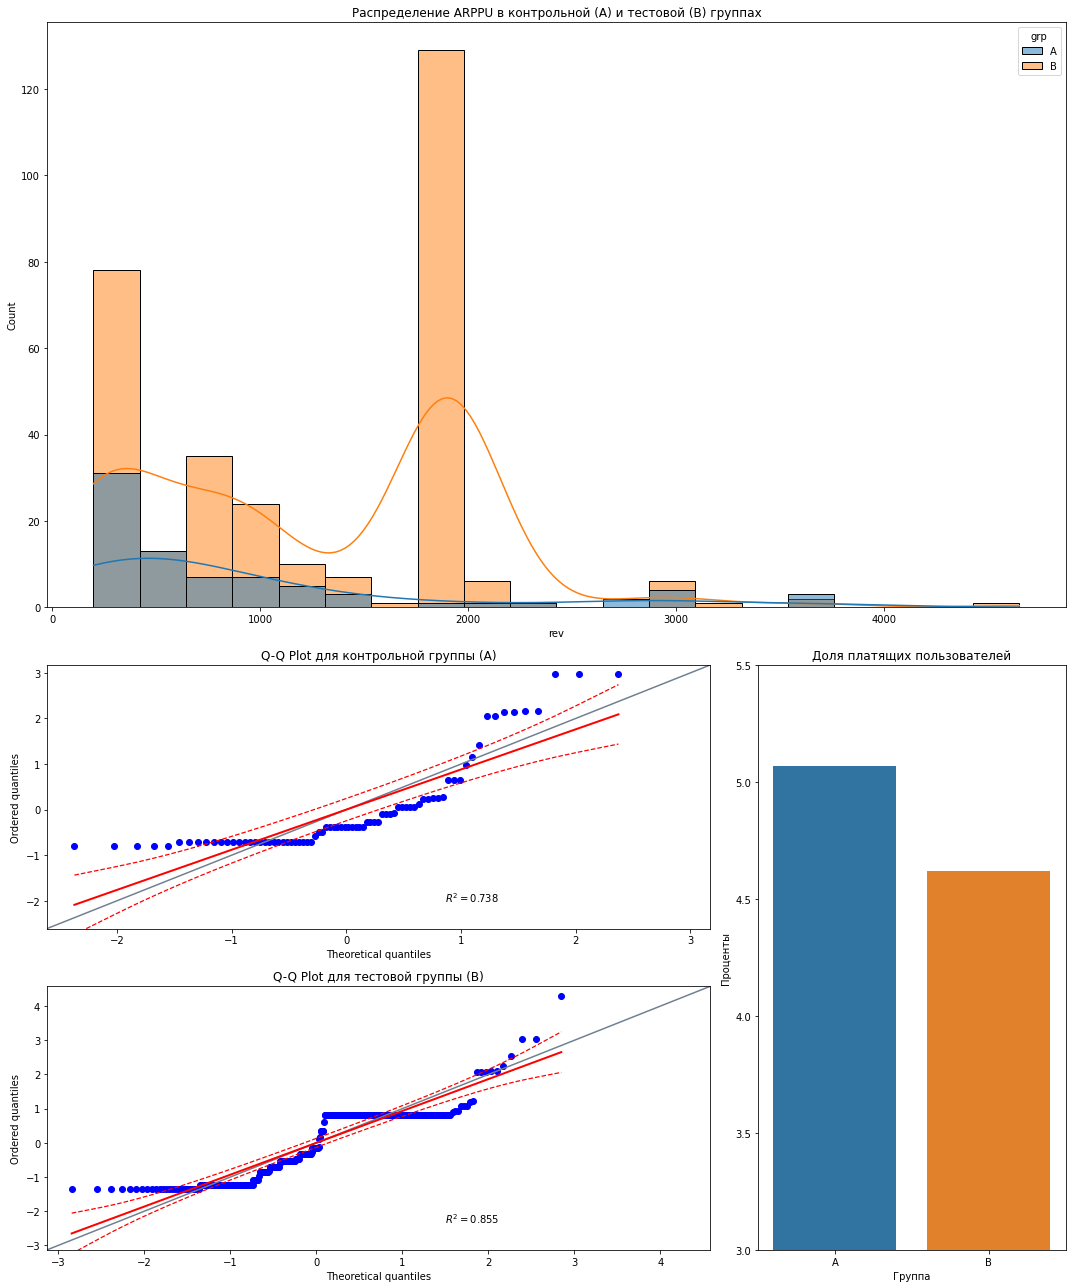

In [41]:
viz_metrics(full_df)

<div id="point5"></div>

###  5. Стоит ли раскатывать новую механику на всех пользователей? ([в начало](#top))

На основании t-критерия мы можем утверждать, что новая механика оказала **статистически значимое положительное влияние** на среднюю выручку с платящего пользователя *(p = 0.005)*. 

Хотя при первичном рассмотрении могло показаться, что доля платящих пользователей по контрольной группе выше, чем по тестовой, не имеется достаточных оснований, чтобы считать данные различия статистически значимыми. 

## **Таким образом, новую механику стоит раскатывать на всех пользователей**. 

Доверительный интервал для дельты, на которую изменится ARPPU при внедрении новой механики, составляет *от 99.64 до 548.94*.